# Hydro 4 samples

__Description__: Prepares the shape of the 4 sampled Atlas 14 nested hyetographs

__Input__: 
- Parameters: noaa precipitation table (*Project ID +_PrecipTable.xlsx*) and duration of events;.
        
- `DataRepository` folder which contains the following:
    - The *Temporal_Distributions* folder, containing [precipitation temporal distribution data](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html) broken down by quartile for the specified volume, region, and duration.

    - The *Temporal_Distribution_Data_Map.json* which contains metadata used to extract the temporal distribution data from its *.csv file.

    - The *Temporal_Quartile_Ranks.xlsx* which contains the percentage of precipitation events whose temporal distributions are represented by those in each quartile. [Source](https://www.nws.noaa.gov/oh/hdsc/currentpf.html). 


__Output__: Samples and weights for hyetograph distributions (*Project ID + _atlas_temporal_PrecipTable.xlsx*)


---

## A. Load Libraries, Parameters, and Data:

### Libraries:

In [1]:
import sys
sys.path.append('../../core')
from hydromet import*

### Parameters: 
#### Local (site specific):

In [2]:
## NOAA parameters:
duration = 12   # Event duration in hour

## Filenames and paths:
Project_Area = 'JoCo'          # Project area name
Pluvial_Model = 'P01'                # Pluvial model name
BCN = 'TurkeyCreek'               # Domain/boundary condition name 071200040505 Kansas 102500170609 Nevada '160600140303'

precip_table = '{0}_{1}_{2}_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN)  # NOAA Data
     
root_dir = pl.Path(os.getcwd())
outputs_dir = root_dir/'Outputs'
precip_table_dir = outputs_dir/precip_table
datarepository_dir = root_dir.parent.parent/'DataRepository'

## Options:
display_plots = True
display_print = True

##### Convert all paths to objects:

In [3]:
precip_table_dir = pl.Path(precip_table_dir)
datarepository_dir = pl.Path(datarepository_dir)
outputs_dir = pl.Path(outputs_dir)

#### Global (project specific):

In [4]:
## Filenames and paths:
Temporal_Distribution_Data_Map = 'Temporal_Distribution_Data_Map.json'
Temporal_Quartile_Ranks = 'Temporal_Quartile_Ranks.xlsx'
temporal_dir = datarepository_dir/'Temporal_Distributions'

### Data:

#### NOAA Atlas 14 Volume and Region:

In [5]:
if 'Volume' not in locals(): 
    volume, region = get_volume_region(precip_table_dir, display_print = display_print)

NOAA Atlas 14: Volume 8, Region 3


#### Temporal distribution data map:

In [6]:
qmap = get_temporal_map(datarepository_dir, Temporal_Distribution_Data_Map, volume, region, duration, display_print)

{'map': {'q1': [0, 25], 'q2': [28, 53], 'q3': [56, 81], 'q4': [84, 109]}, 'skiprows': 8}


#### Precipitation temporal distribution:

In [7]:
raw_temporals = get_temporals(temporal_dir, volume, region, duration, qmap, display_print)

,90%,80%,70%,60%,50%,40%,30%,20%,10%
hours,,,,,,,,,
0,0,0,0,0,0,0,0,0,0
0.5,1.26,2.02,3.68,5.74,8.74,11.84,14.92,21.17,30.44


None


#### Temporal quartile ranks:

In [8]:
qrank = get_quartile_rank(datarepository_dir, Temporal_Quartile_Ranks, volume, region, duration, display_print)

[0.56, 0.22, 0.14, 0.08]


---

## Show Temporal Distributions:

### Reformat and plot the temporal distribution data:

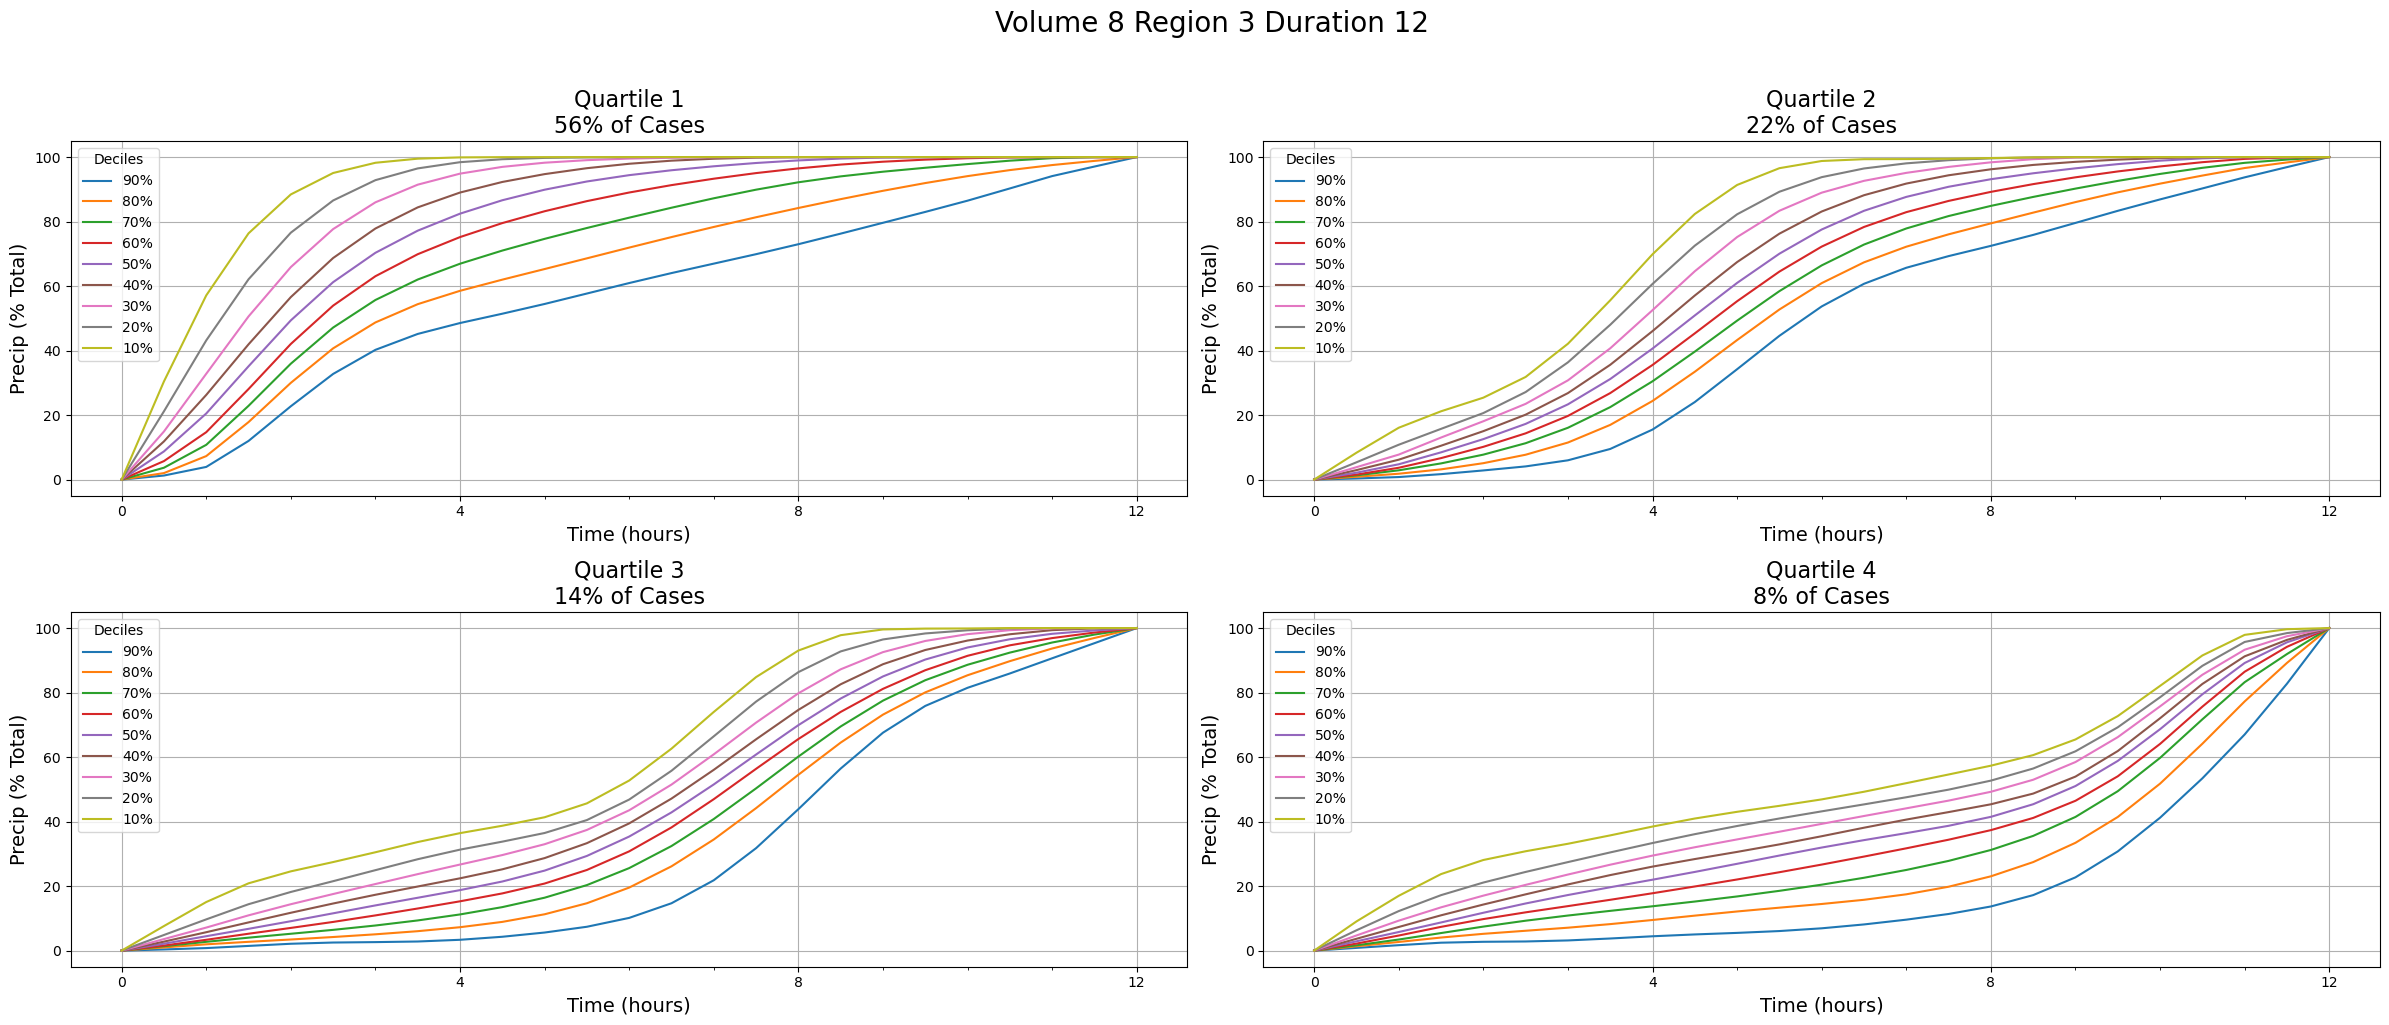

In [9]:
curve_group = get_quartiles(raw_temporals, duration, qrank, qmap, volume, region, plot = display_plots)

## Select Temporal Distributions:

#### Combine deciles and quartiles into 1 dataframe

In [10]:
all_distro = pd.concat([curve_group['q1'], curve_group['q2'], curve_group['q3'], curve_group['q4']], axis=1, keys=['q1','q2','q3','q4'])
all_distro.head(2)

q1                                                        q2  ...  \
        90%   80%   70%   60%   50%    40%    30%    20%    10%   90%  ...   
hours                                                                  ...   
0.0    0.00  0.00  0.00  0.00  0.00   0.00   0.00   0.00   0.00  0.00  ...   
0.5    1.26  2.02  3.68  5.74  8.74  11.84  14.92  21.17  30.44  0.35  ...   

         q3    q4                                                  
        10%   90%   80%   70%   60%   50%   40%   30%   20%   10%  
hours                                                              
0.0    0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  
0.5    7.61  0.84  1.34  1.64  2.17  2.88  3.66  4.69  6.29  9.04  

[2 rows x 36 columns]

#### Set Sampling Plan

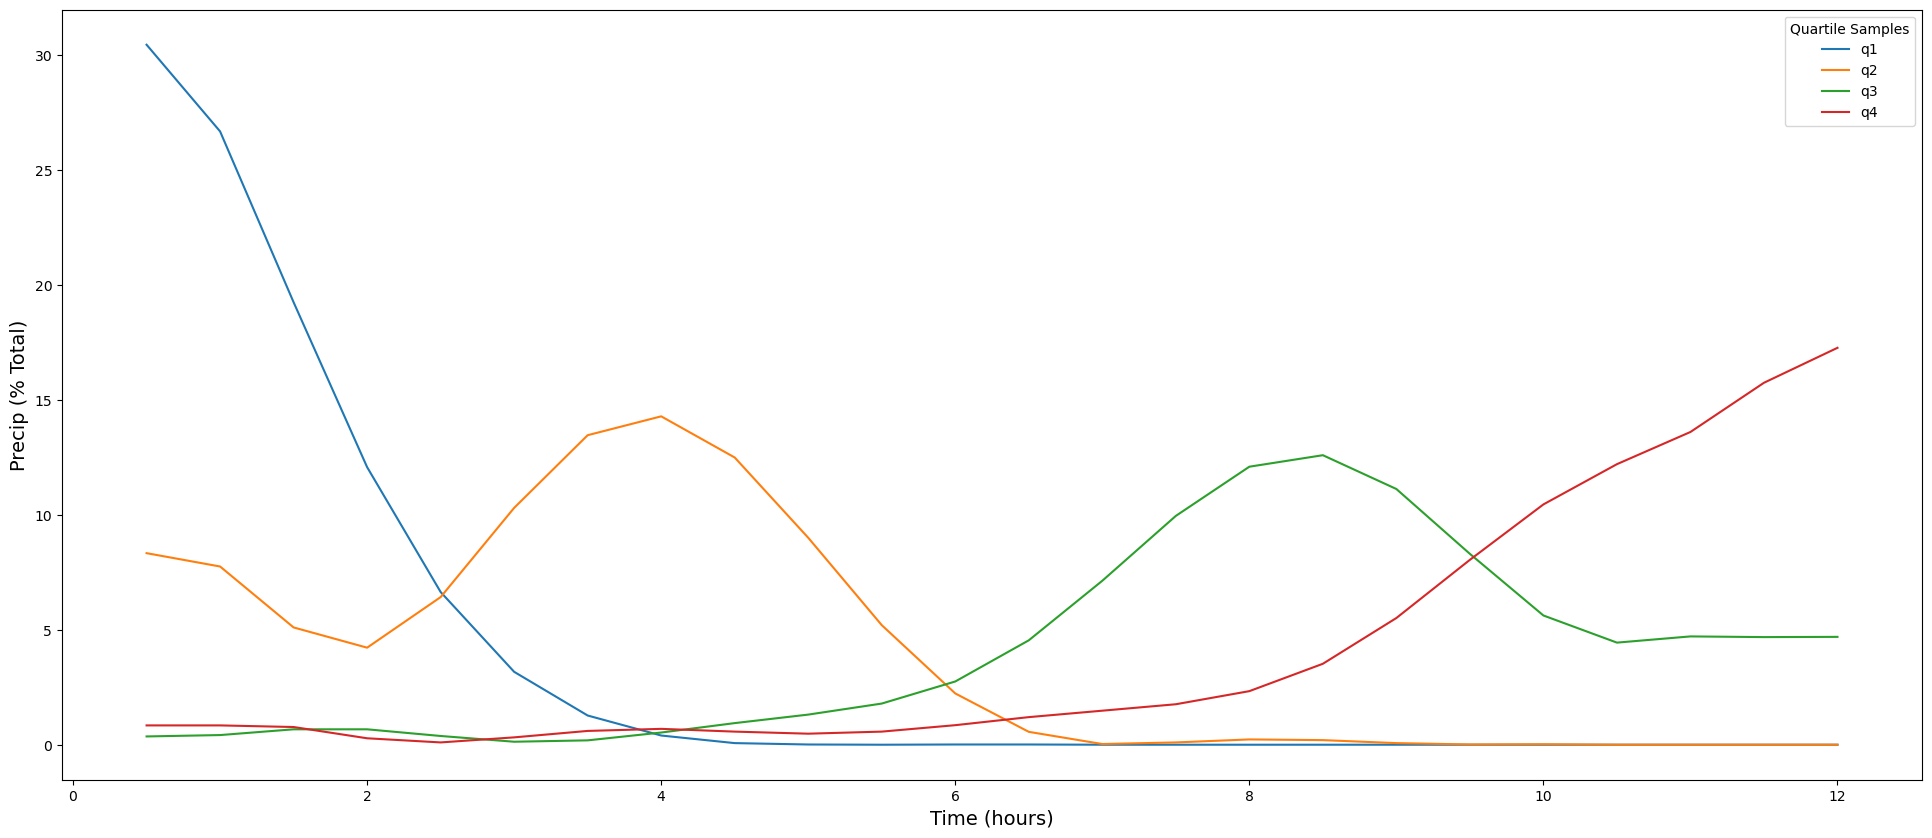

In [11]:
## User selected limiting sample from each quartile:
samples = ['10%', '10%', '90%', '90%']

## Plot selected samples:
select_distro = pd.concat([all_distro['q1'][samples[0]], all_distro['q2'][samples[1]], all_distro['q3'][samples[2]], all_distro['q4'][samples[3]]], axis=1, keys=['q1','q2','q3','q4'])
select_distro_hyetograph = pd.concat([all_distro.diff()['q1'][samples[0]], all_distro.diff()['q2'][samples[1]], all_distro.diff()['q3'][samples[2]], all_distro.diff()['q4'][samples[3]]], axis=1,keys=['q1', 'q2', 'q3', 'q4'])
ax = select_distro_hyetograph.plot(figsize=(24, 10))
ax.legend(title = 'Quartile Samples')
ax.set_xlabel('Time (hours)', fontsize=14)
ax.set_ylabel('Precip (% Total)', fontsize=14)
ax.plot();

#### Check sample weights

In [12]:
## Weighted probability of each sample:
weights_df = pd.DataFrame(data = qrank, columns = ['weight'])
weights_df.index = ['q1', 'q2', 'q3', 'q4']
weights_df

,weight
q1,0.56
q2,0.22
q3,0.14
q4,0.08


---

## Save the Results:

In [13]:
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}_atlas_temporal_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN))

for i, d in enumerate(select_distro.columns):
    table = select_distro[d]/100.0
    table.to_excel(writer, sheet_name = f'atlas_hye_{d}')
weights_df.to_excel(writer, sheet_name = 'atlas_hye_weights')
 
writer.close()

---

## END